In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from typing import List, Tuple, Dict, Any, Optional
from td.environments import (
    Blockworld,
    Environment,
    Rainbow,
    TinySVG,
    NanoSVG,
    CSG2D,
    TinySVGOffset,
    environments,
)
from td.grammar import Grammar
from td.samplers import ConstrainedRandomSampler
from td.samplers.mutator import (
    Mutation,
    random_mutation,
    AddParents,
    forward_process,
    forward_process_with_guards,
)
from td.learning.tokenizer import Tokenizer
from td.learning.constrained_decoding import DecoderState
from lark import Token
from lark.parsers.lalr_interactive_parser import InteractiveParser
from collections import defaultdict
import random
import tqdm
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state
import enum
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import iceberg as ice
from lark import Tree, Transformer
from td.grammar import Grammar, Compiler
from td.environments.environment import Environment
from td.environments.goal_checker import GaussianImageGoalChecker


jnp.set_printoptions(suppress=True)
np.set_printoptions(suppress=True)

In [5]:
# env = Rainbow()
# env = Blockworld()
# env = TinySVG()
# env = NanoSVG()
# env = CSG2D()
# env = TinySVGOffset()
env_name = "csg2da"
env = environments[env_name]()
sampler = ConstrainedRandomSampler(env.grammar)
tokenizer = Tokenizer(env.grammar)

In [6]:
random.seed(2)
expr = sampler.sample(env.grammar.start_symbol, min_primitives=4, max_primitives=7)
print(expr)
print(env.grammar.parse(expr).pretty())

(+ (- (Quad 1 9 5 0 N) (Circle B 5 5)) (- (Quad E 5 F B J) (Quad E E 8 7 L)))
s
  binop
    add
    s
      binop
        subtract
        s
          quad
            one
            nine
            five
            zero
            sevendeg
        s
          circle
            eleven
            five
            five
    s
      binop
        subtract
        s
          quad
            fourteen
            five
            fifteen
            eleven
            threedeg
        s
          quad
            fourteen
            fourteen
            eight
            seven
            fivedeg



In [7]:
sampler.sample(env.grammar.start_symbol, min_primitives=2, max_primitives=2)

'(+ (Circle 6 1 B) (Circle D 7 3))'

In [8]:
expr = sampler.sample(env.grammar.start_symbol, min_primitives=2, max_primitives=2)
mut = random_mutation(expr, env.grammar, sampler)
print(mut.pretty(expr))

(+ (Circle 5 7 5) (Quad B 9 9 F G))
                  ^^^^^^^^^^^^^^^^ --> (+ (Circle 5 3 7) (Quad A 8 A C G))


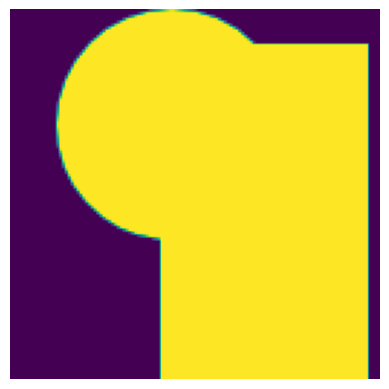

In [9]:
img = env.compile(
    # "(Arrange h (Arrange h (Arrange h (Box purple) (Ball purple)) (Box red)) (Arrange v (Box yellow) (Box orange)))"
    # "(Arrange h (Rectangle 4 4 blue none 4) (Move (Ellipse 9 9 red black 2) 1 3 true true) 1)"
    expr
)
plt.imshow(img)
plt.axis("off")
plt.show()
# img.scale(10)
# img

100%|██████████| 10000/10000 [00:04<00:00, 2098.11it/s]


Max length 175
Mean length 90.8094
Median length 91.0
Min length 23


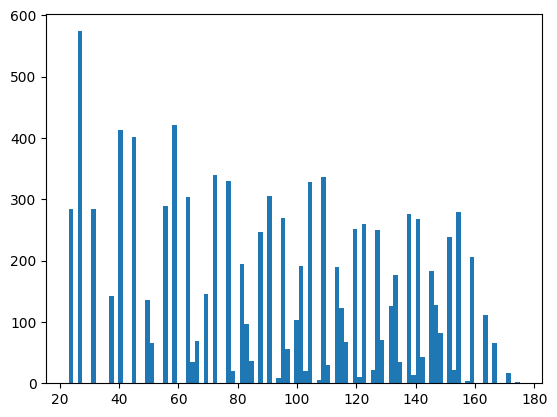

In [10]:
def sampler_lengths(
    env: Environment,
    sampler: ConstrainedRandomSampler,
    tokenizer: Tokenizer,
    N: int = 10000,
):
    return [
        len(
            tokenizer._tokenize_one(
                sampler.sample(
                    env.grammar.start_symbol, min_primitives=2, max_primitives=10
                )
            )
        )
        for _ in tqdm.trange(N)
    ]


lengths = sampler_lengths(env, sampler, tokenizer, N=10000)
print("Max length", max(lengths))
print("Mean length", np.mean(lengths))
print("Median length", np.median(lengths))
print("Min length", min(lengths))
plt.hist(lengths, bins=100)
plt.show()

In [13]:
def mutation_length_effects(
    env: Environment,
    sampler: ConstrainedRandomSampler,
    tokenizer: Tokenizer,
    N: int = 10000,
):
    shorter = 0
    equal = 0
    longer = 0

    for _ in tqdm.trange(N):
        expr = sampler.sample(env.grammar.start_symbol)
        mut = random_mutation(expr, env.grammar, sampler)
        new_expr = mut.apply(expr)

        expr = tokenizer._tokenize_one(expr)
        new_expr = tokenizer._tokenize_one(new_expr)

        if len(new_expr) < len(expr):
            shorter += 1
        elif len(new_expr) == len(expr):
            equal += 1
        else:
            longer += 1

    return shorter / N, equal / N, longer / N


shorter, equal, longer = mutation_length_effects(env, sampler, tokenizer, N=10000)
print(
    f"Shorter: {shorter*100:.2f}%, Equal: {equal*100:.2f}%, Longer: {longer*100:.2f}%"
)

100%|██████████| 10000/10000 [00:15<00:00, 633.01it/s]

Shorter: 30.79%, Equal: 49.24%, Longer: 19.97%


In [34]:
def token_counts(
    env: Environment,
    tokenizer: Tokenizer,
    sampler: ConstrainedRandomSampler,
    N: int = 10000,
):
    counts = defaultdict(int)
    for _ in tqdm.trange(N):
        expr = sampler.sample(
            env.grammar.start_symbol, min_primitives=7, max_primitives=7
        )
        tokens = tokenizer._tokenize_one(expr)
        for t in tokens:
            counts[t] += 1

    counts = {
        tokenizer._untokenize_one([k]): v
        for k, v in sorted(counts.items(), key=lambda x: -x[1])
    }
    return counts


counts = token_counts(env, tokenizer, sampler, N=10000)
counts

100%|██████████| 10000/10000 [00:06<00:00, 1528.44it/s]


{' ': 399640,
 '(': 130000,
 ')': 130000,
 'Circle': 35180,
 'Quad': 34820,
 '-': 30177,
 '+': 29823,
 'B': 15610,
 '0': 15438,
 '4': 15425,
 'C': 15396,
 '6': 15366,
 '2': 15325,
 'F': 15315,
 '5': 15285,
 '8': 15285,
 'D': 15281,
 '1': 15242,
 '9': 15218,
 '7': 15208,
 '3': 15206,
 'E': 15113,
 'A': 15107,
 'L': 4416,
 'G': 4382,
 'M': 4357,
 'I': 4349,
 'H': 4340,
 'N': 4337,
 'K': 4330,
 'J': 4309}

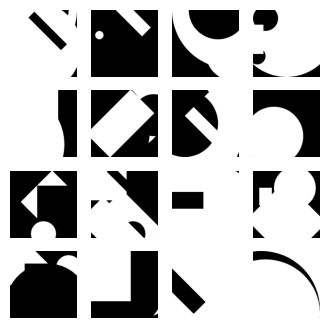

In [11]:
expressions = [
    env.sample_non_empty(
        lambda: sampler.sample(env.grammar.start_symbol, max_primitives=7)
    )
    for _ in range(16)
]
images = np.array([env.compile(e) for e in expressions])
images = images.reshape((4, 4) + env.compiled_shape)
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(images[i, j], cmap="gray")
        axes[i, j].axis("off")
plt.show()

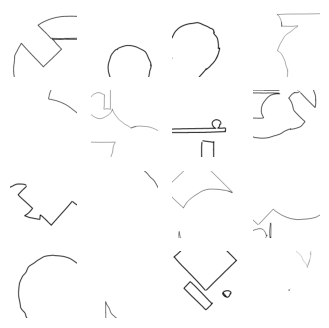

In [39]:
expressions = [
    env.sample_non_empty(
        lambda: sampler.sample(env.grammar.start_symbol, max_primitives=7)
    )
    for _ in range(16)
]
images = np.array([env.compile_observation(e) for e in expressions])
images = images.reshape((4, 4) + env.compiled_shape)
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(images[i, j], cmap="gray")
        axes[i, j].axis("off")
plt.show()

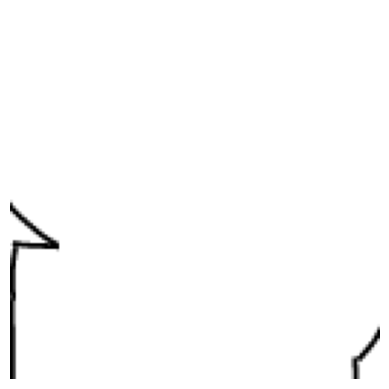

In [114]:
expr = sampler.sample(env.grammar.start_symbol, min_primitives=2, max_primitives=10)
plt.imshow(env.compile_observation(expr), cmap="gray")
plt.axis("off")
plt.show()

In [87]:
expr = sampler.sample(env.grammar.start_symbol, min_primitives=7, max_primitives=7)
print(expr)

(- (+ (Circle 2 B 0) (+ (Circle F 7 E) (Circle 3 4 F))) (+ (+ (Circle 9 B 0) (Circle 1 F 9)) (- (Circle 3 4 5) (Circle 6 D B))))


In [44]:
mut = random_mutation(expr, env.grammar, sampler)
print(mut.pretty(expr))

(+ (- (+ (Circle 3 4 8) (Circle 2 3 B)) (Quad 9 B 5 6 H)) (- (- (Quad F A E 5 J) (Circle 2 4 7)) (+ (Circle 7 9 D) (Circle E F 7))))
                                                                                                            ^ --> 0


In [60]:
def sample_forward_process(N=10000):
    target_expressions = [
        sampler.sample(
            env.grammar.start_symbol,
            min_primitives=2,
            max_primitives=8,
        )
        for _ in range(N)
    ]
    steps = [random.randint(1, 5) for _ in range(N)]
    training_examples = [
        forward_process_with_guards(expression, step, env.grammar, sampler)
        for expression, step in tqdm.tqdm(zip(target_expressions, steps), total=N)
    ]
    tokenized_forwards = [
        (tokenizer._tokenize_one(expr), tokenizer._tokenize_one(m.replacement))
        for expr, m in training_examples
    ]
    lengths = [len(expr) + len(a) + 1 + 1 + 1 for expr, a in tokenized_forwards]
    print("Max length", max(lengths))
    print("Mean length", np.mean(lengths))
    print("Median length", np.median(lengths))
    print("Min length", min(lengths))


sample_forward_process(N=10000)

  5%|▌         | 529/10000 [00:02<00:43, 217.33it/s]

KeyboardInterrupt: 

(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle 7 B 5) (+ (Circle B 8 A) (Quad 5 5 0 D L))))


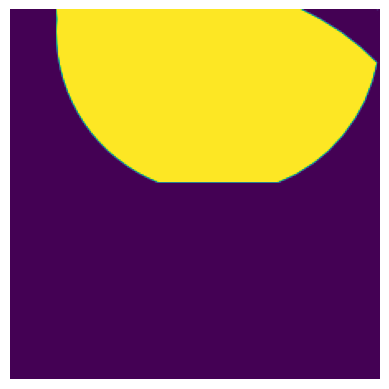

(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle 7 B 5) (+ (Circle B 8 A) (Quad 5 5 0 D L))))
                                                                                         ^ --> B
(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle 7 B 5) (+ (Circle B B A) (Quad 5 5 0 D L))))


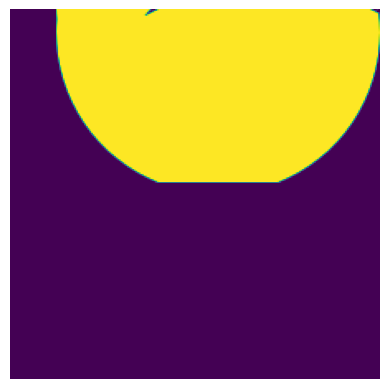

(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle 7 B 5) (+ (Circle B B A) (Quad 5 5 0 D L))))
                                                             ^^^^^^^^^^^^^^ --> (Circle F 9 8)
(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle F 9 8) (+ (Circle B B A) (Quad 5 5 0 D L))))


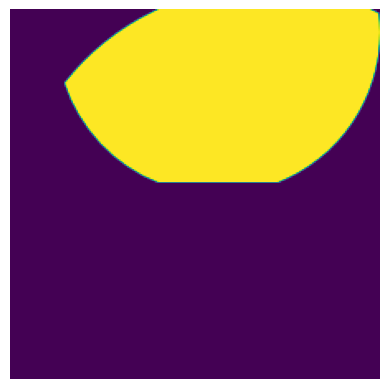

(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle F 9 8) (+ (Circle B B A) (Quad 5 5 0 D L))))
                                                                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ --> (Circle 8 8 8)
(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle F 9 8) (Circle 8 8 8)))


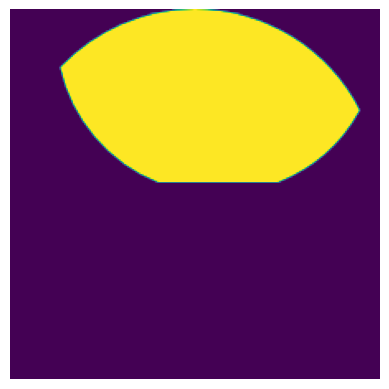

(- (+ (Circle 4 6 0) (- (Circle 7 9 1) (Quad C E D F I))) (- (Circle F 9 8) (Circle 8 8 8)))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ --> (Circle 8 8 0)
(- (+ (Circle 4 6 0) (Circle 8 8 0)) (- (Circle F 9 8) (Circle 8 8 8)))


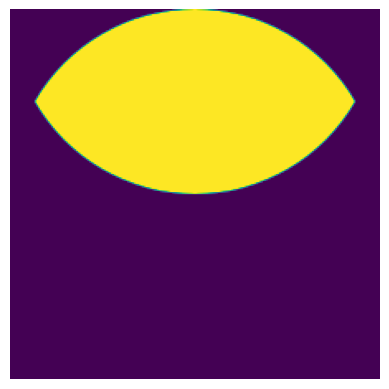

(- (+ (Circle 4 6 0) (Circle 8 8 0)) (- (Circle F 9 8) (Circle 8 8 8)))
                                                  ^ --> B


  5%|▌         | 529/10000 [00:17<00:43, 217.33it/s]

In [61]:
current_expression = sampler.sample(
    env.grammar.start_symbol, min_primitives=2, max_primitives=7
)

for _ in range(5):
    print(current_expression)
    current_image = env.compile(current_expression)
    plt.imshow(current_image)
    plt.axis("off")
    plt.show()

    mut = random_mutation(current_expression, env.grammar, sampler)
    print(mut.pretty(current_expression))
    current_expression = mut.apply(current_expression)

In [ ]:
# Find confusing mutations.

